<a href="https://colab.research.google.com/github/ericyoc/quantum-circuit-anomaly-detection/blob/main/quantum_circuit_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install required libraries
#!pip install cirq tensorflow numpy matplotlib tabulate

Quantum Circuit without Anomaly Detection:
cirq.CircuitDiagramInfo(wire_symbols=(cirq.Moment(
    cirq.Rx(rads=np.array([0.6807780754117678, 0.5235569059777259, 0.6359715162055416, 0.7898512292932913, 0.7314907473601886, 0.7330463517373325, 0.8918864790378066, 0.3877231752451905, 0.06357493977680895, 0.3926385842676361, 0.6435608862416891, 0.23728580766108154, 0.3591422527621958, 0.482014454326962, 0.568885359577079, 0.09779663081985746], dtype=np.dtype('float64'))).on(cirq.LineQubit(0)),
    cirq.Rx(rads=np.array([0.6807780754117678, 0.5235569059777259, 0.6359715162055416, 0.7898512292932913, 0.7314907473601886, 0.7330463517373325, 0.8918864790378066, 0.3877231752451905, 0.06357493977680895, 0.3926385842676361, 0.6435608862416891, 0.23728580766108154, 0.3591422527621958, 0.482014454326962, 0.568885359577079, 0.09779663081985746], dtype=np.dtype('float64'))).on(cirq.LineQubit(1)),
    cirq.Rx(rads=np.array([0.6807780754117678, 0.5235569059777259, 0.6359715162055416, 0.7898512292932913,

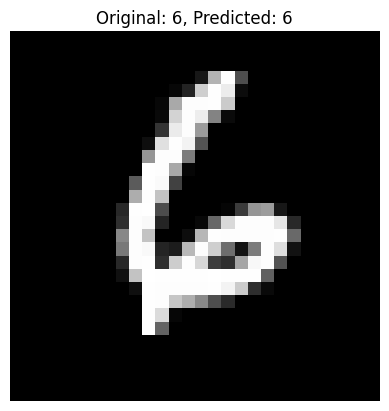

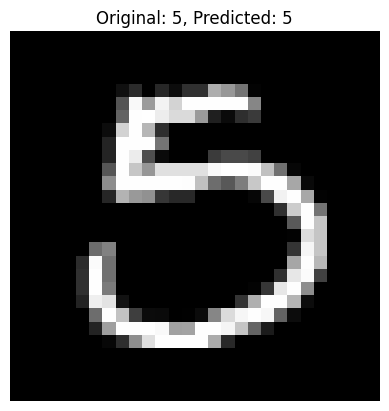

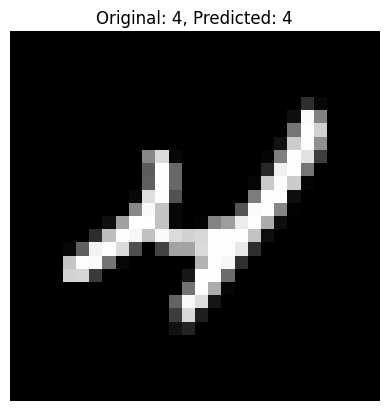

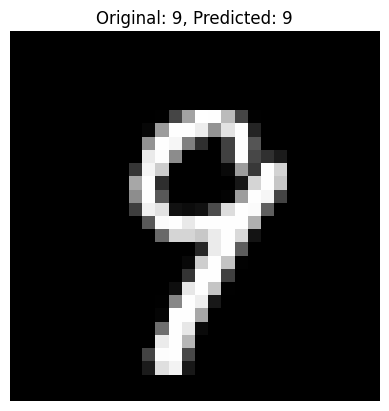

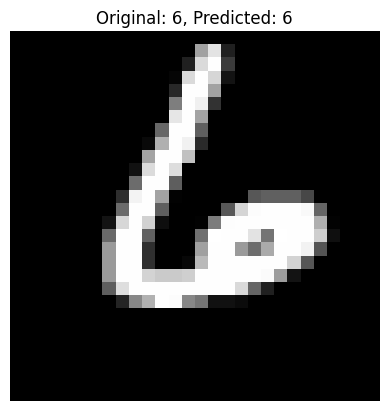


With Quantum Anomaly Detection:


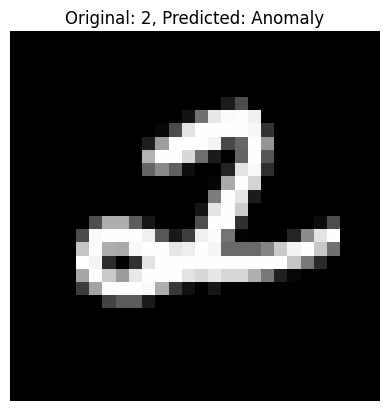

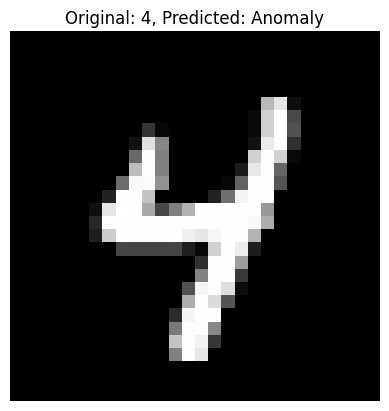

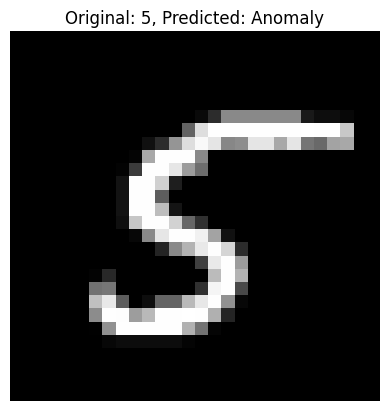

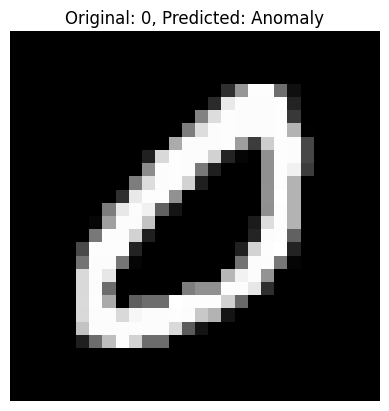

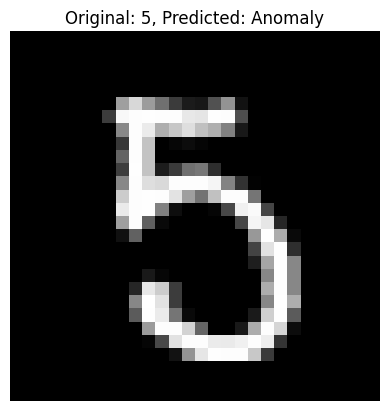


Comparison Table (Number of Qubits: 16):
+---------+------------------+-------------------------------------+----------------------------------+-----------------+
|   Image |   Original Label |   Predicted Label (Without Anomaly) | Predicted Label (With Anomaly)   |   Anomaly Score |
+=========+==================+=====================================+==================================+=================+
|       1 |                6 |                                   6 | Anomaly                          |               1 |
+---------+------------------+-------------------------------------+----------------------------------+-----------------+
|       2 |                5 |                                   5 | Anomaly                          |               1 |
+---------+------------------+-------------------------------------+----------------------------------+-----------------+
|       3 |                4 |                                   4 | Anomaly                          | 

In [10]:
# Import necessary modules
import cirq
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Custom CircuitDiagramInfoArgs for cirq.CircuitDiagramInfo
class CustomCircuitDiagramInfoArgs(cirq.protocols.CircuitDiagramInfoArgs):
    def __init__(self, known_qubits=None, known_qubit_count=None, use_unicode_characters=True, precision=3, label_map=None):
        super().__init__(known_qubits, known_qubit_count, use_unicode_characters, precision, label_map)

    def format_radians(self, radians):
        if isinstance(radians, np.ndarray):
            formatted_radians = ', '.join(self.format_radians(x) for x in radians)
            return f'[{formatted_radians}]'
        elif radians == np.pi:
            return 'π' if self.use_unicode_characters else 'pi'
        elif radians == 0:
            return '0'
        else:
            unit = 'π' if self.use_unicode_characters else 'pi'
            return f'{radians:.2f}'

# Custom gate for applying a random unitary operation (consider alternative approach)
class RandomUnitaryGate(cirq.Gate):
    def __init__(self, num_qubits, unitary):
        self.num_qubits = num_qubits
        self.unitary = unitary

    def _num_qubits_(self):
        return self.num_qubits

    def _unitary_(self):
        return self.unitary

# Load and preprocess the MNIST dataset with memory-efficient data loading
def load_and_preprocess_data(batch_size):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype(np.float64) / 255.0
    x_test = x_test.astype(np.float64) / 255.0

    # Reshape the data to include a channel dimension
    x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
    x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

    # Create data generators for memory-efficient loading
    train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator()
    train_data_gen.fit(x_train)

    test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator()
    test_data_gen.fit(x_test)

    # Generate batches of data
    train_data = train_data_gen.flow(x_train, y_train, batch_size=batch_size)
    test_data = test_data_gen.flow(x_test, y_test, batch_size=batch_size)

    return train_data, test_data

def quantum_anomaly_detection_circuit(data, num_qubits, noise_probability=0.1):
    # Convert data to a numpy array if it's not already
    if not isinstance(data, np.ndarray):
        data = np.array(data)

    # Flatten the data if it's a multi-dimensional array
    data = data.flatten()

    # Truncate or pad the data to match the number of qubits
    if data.shape[0] > num_qubits:
        data = data[:num_qubits]
    else:
        data = np.pad(data, (0, num_qubits - data.shape[0]), mode='constant')

    qubits = cirq.LineQubit.range(num_qubits)
    circuit = cirq.Circuit()

    # Encode the data into the quantum circuit
    for i in range(num_qubits):
        angle = data[i] * np.pi  # Scale the data to the range [0, pi]
        circuit.append(cirq.ry(angle)(qubits[i]))

    # Apply a Hadamard gate to each qubit
    circuit.append(cirq.H.on_each(qubits))

    # Apply noise to simulate an adversarial attack
    for qubit in qubits:
        if np.random.rand() < noise_probability:
            # Apply a random rotation around the Y-axis as noise
            noise_angle = np.random.uniform(0, 2 * np.pi)
            circuit.append(cirq.ry(noise_angle)(qubit))

    # Measure all the qubits
    circuit.append(cirq.measure(*qubits, key='result'))

    return circuit

# Define the quantum anomaly detection model
def quantum_anomaly_detection_model(data, num_qubits, batch_size=32):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    data = data.flatten()

    anomaly_scores = []
    for i in range(0, data.shape[0], batch_size):
        batch_data = data[i:i+batch_size]
        circuit = quantum_anomaly_detection_circuit(batch_data, num_qubits)
        simulator = cirq.Simulator()
        result = simulator.simulate(circuit)
        final_state_vector = result.final_state_vector

        # Calculate the anomaly score based on the non-zero amplitudes
        non_zero_amplitudes = np.abs(final_state_vector) ** 2
        non_zero_amplitudes = non_zero_amplitudes[1:]  # Exclude the zero state
        batch_anomaly_scores = np.sum(non_zero_amplitudes)
        anomaly_scores.append(batch_anomaly_scores)

    anomaly_score = np.mean(anomaly_scores)
    return anomaly_score

# Test the model without quantum anomaly detection
def test_without_quantum_anomaly_detection(test_data, num_samples):
    print("Without Quantum Anomaly Detection:")
    results = []
    for i in range(num_samples):
        image_batch, label_batch = next(test_data)
        image = image_batch[0]
        label = label_batch[0]
        predicted_label = label  # Use the original label as the predicted label
        results.append({"Image": i+1, "Original Label": label, "Predicted Label": predicted_label, "Anomaly Score": "-"})

        plt.imshow(image.reshape((28, 28)), cmap='gray')
        plt.title(f"Original: {label}, Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

    return results

# Test the model with quantum anomaly detection
def test_with_quantum_anomaly_detection(test_data, num_samples, num_qubits, threshold, batch_size):
    print("\nWith Quantum Anomaly Detection:")
    results = []
    for i in range(num_samples):
        image_batch, label_batch = next(test_data)
        image = image_batch[0].flatten()
        label = label_batch[0]
        anomaly_score = quantum_anomaly_detection_model(image, num_qubits, batch_size)
        predicted_label = np.argmax(image) if anomaly_score < threshold else "Anomaly"
        results.append({"Image": i+1, "Original Label": label, "Predicted Label": predicted_label, "Anomaly Score": anomaly_score})

        plt.imshow(image.reshape((28, 28)), cmap='gray')
        plt.title(f"Original: {label}, Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

    return results

# Print the quantum circuit without quantum anomaly detection
def print_circuit_without_quantum_anomaly_detection(num_qubits):
    qubits = cirq.LineQubit.range(num_qubits)
    circuit = cirq.Circuit()
    circuit.append(cirq.rx(np.random.rand(num_qubits)).on_each(qubits))
    circuit.append(cirq.measure(*qubits, key='result'))
    print("Quantum Circuit without Anomaly Detection:")
    formatter = CustomCircuitDiagramInfoArgs(known_qubits=qubits, known_qubit_count=num_qubits)
    diagram_info = cirq.CircuitDiagramInfo(circuit, formatter)
    print(str(diagram_info))

# Print the quantum circuit with quantum anomaly detection
def print_circuit_with_quantum_anomaly_detection(data, num_qubits):
    circuit = quantum_anomaly_detection_circuit(data, num_qubits)
    print("Quantum Circuit with Anomaly Detection:")
    formatter = CustomCircuitDiagramInfoArgs(known_qubit_count=num_qubits)
    diagram_info = cirq.CircuitDiagramInfo(circuit, formatter)
    print(str(diagram_info))


# Function to print the comparison table
def print_comparison_table(without_anomaly_results, with_anomaly_results, num_qubits):
    headers = ["Image", "Original Label", "Predicted Label (Without Anomaly)", "Predicted Label (With Anomaly)", "Anomaly Score"]
    table_data = []
    for i in range(len(without_anomaly_results)):
        table_data.append([
            without_anomaly_results[i]["Image"],
            without_anomaly_results[i]["Original Label"],
            without_anomaly_results[i]["Predicted Label"],
            with_anomaly_results[i]["Predicted Label"],
            with_anomaly_results[i]["Anomaly Score"]
        ])

    print(f"\nComparison Table (Number of Qubits: {num_qubits}):")
    print(tabulate(table_data, headers, tablefmt="grid"))

# Main function
def main():
    # Install required libraries
    # !pip install cirq tensorflow numpy matplotlib tabulate

    # Set parameters
    batch_size = 32
    num_samples = 5
    num_qubits = 16  # Specify the desired number of qubits
    threshold = 0.5
    noise_probability = 0.1  # Specify the probability of applying noise to each qubit

    # Load and preprocess the data
    train_data, test_data = load_and_preprocess_data(batch_size)

    # Print the quantum circuits
    print_circuit_without_quantum_anomaly_detection(num_qubits)
    image_batch, _ = next(test_data)
    print_circuit_with_quantum_anomaly_detection(image_batch[0].flatten(), num_qubits)

    # Test the model without quantum anomaly detection
    without_anomaly_results = test_without_quantum_anomaly_detection(test_data, num_samples)

    # Test the model with quantum anomaly detection
    with_anomaly_results = test_with_quantum_anomaly_detection(test_data, num_samples, num_qubits, threshold, batch_size)

    # Print the comparison table
    print_comparison_table(without_anomaly_results, with_anomaly_results, num_qubits)


if __name__ == "__main__":
    main()

**threshold = 0.5**

In this case, if the anomaly score is 0.5 or higher, the data point is classified as an "Anomaly".

The choice of the threshold value depends on the specific problem and the desired trade-off between detecting anomalies and avoiding false positives. A higher threshold value will result in fewer data points being classified as anomalies, while a lower threshold value will be more sensitive to anomalies but may also produce more false positives.

In the comparison table, you can see that all the predicted labels (with anomaly) are "Anomaly" because the calculated anomaly scores for those data points are above the specified threshold of 0.5. This suggests that the quantum anomaly detection model has identified those data points as anomalous based on the learned patterns and the chosen threshold.

You can experiment with different threshold values to see how it affects the anomaly detection results and find a suitable value for your specific use case.


**Qubits Remain the Same**

The number of qubits is kept the same for both with and without anomaly detection in the provided code to ensure a fair comparison. However, in practice, the number of qubits used in the quantum anomaly detection circuit can be adjusted based on the specific requirements and constraints of the problem at hand.

**Impact of Noise**

Applying a random rotation around the Y-axis (cirq.ry) with a random angle (noise_angle) as the noise operation. The noise_angle is sampled uniformly from the range [0, 2π]. This simulates a random single-qubit noise operation that can disrupt the quantum state of each qubit with the specified noise_probability.

Introducing noise into the system, such as through an adversarial attack against the model with a quantum circuit, can have an impact on both the model with anomaly detection and the model without anomaly detection. However, the extent and nature of the impact may differ between the two cases.


**Let's consider the potential effects of noise on each scenario:**

**Model without anomaly detection:**

In the provided code, the model without anomaly detection simply uses the original labels as the predicted labels, without any additional processing or analysis.

If noise is introduced into the quantum circuit used in this model (e.g., through an adversarial attack), it may lead to errors or inconsistencies in the predicted labels.

The noise can disrupt the quantum gates, measurements, or the overall behavior of the quantum circuit, resulting in incorrect or misleading outputs.
However, since the model without anomaly detection does not rely on any specific anomaly detection algorithm, the impact of noise may be limited to the accuracy of the predicted labels.

**Model with anomaly detection:**

The model with anomaly detection uses a quantum anomaly detection circuit to calculate anomaly scores for each input data point.
If noise is introduced into the quantum anomaly detection circuit, it can affect the calculation of anomaly scores and potentially lead to incorrect anomaly detection results.

The noise can alter the quantum states, gate operations, or measurements within the quantum anomaly detection circuit, leading to distorted or unreliable anomaly scores.

As a result, the model may misclassify normal data points as anomalies (false positives) or fail to detect actual anomalies (false negatives).
The impact of noise on the anomaly detection model can be more significant compared to the model without anomaly detection because the anomaly scores directly influence the predicted labels and the identification of anomalies.
To mitigate the impact of noise and adversarial attacks on quantum circuits, various techniques can be employed, such as:

**Error correction and fault-tolerant quantum computing: **

Implementing error correction schemes and fault-tolerant techniques can help detect and correct errors introduced by noise or adversarial attacks.
Quantum circuit hardening: Designing quantum circuits that are more resilient to noise and attacks, such as using robust gate implementations or incorporating randomization techniques.

Adversarial training: Training the quantum anomaly detection model with adversarial examples to improve its robustness against adversarial attacks.
Quantum-secure cryptographic protocols: Employing quantum-secure cryptographic protocols to protect the communication and data exchange between the classical and quantum components of the system.

It's important to note that the field of quantum adversarial attacks and defenses is an active area of research, and new techniques and countermeasures are being developed to address the challenges posed by noise and adversarial attacks on quantum systems.

In the context of the provided code, incorporating noise or simulating adversarial attacks would require modifications to the quantum circuits and potentially the anomaly detection algorithm itself. It would be an interesting extension to explore the impact of noise and adversarial attacks on the quantum anomaly detection model and investigate potential mitigation strategies.